In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
# we are dropping the following features:
# - "fnlwgt": this feature was created while studying the "adult" dataset.
#   Thus, we will not use this feature which is not acquired during the survey.
# - "education-num": it is encoding the same information than "education".
#   Thus, we are removing one of these 2 features.
df = df.drop(columns=['fnlwgt', 'education-num'])

y = pd.Series(
    LabelEncoder().fit_transform(y),
    name=y.name
)

###############################################################################
# The "adult" dataset as a class ratio of about 3:1

classes_count = y.value_counts()
print(classes_count)

###############################################################################
# This dataset is only slightly imbalanced. To better highlight the effect of
# learning from an imbalanced dataset, we will increase its ratio to 10:1

import numpy as np

rng = np.random.RandomState(0)

# we define a ratio 10:1
n_samples_minority_class = classes_count.max() // 10

mask_minority_class = y == classes_count.idxmin()
indices_minority_class = np.flatnonzero(mask_minority_class)
indices_minority_class_subsampled = rng.choice(
    indices_minority_class, size=n_samples_minority_class, replace=False
)

# sample the dataframe
df_res = pd.concat([df.loc[~mask_minority_class, :],
                    df.loc[indices_minority_class_subsampled, :]])
# sample the target
y_res = pd.concat([y.loc[~mask_minority_class],
                   y.loc[indices_minority_class_subsampled]])
print(y_res.value_counts())

###############################################################################
# For the rest of the notebook, we will make a single split to get training
# and testing data. Note that in practise, you should always use
# cross-validation to have an estimate of the performance variation. You can
# refer to the following example showing how to use a scikit-learn pipeline
# within a grid-search:
# :ref:`sphx_glr_auto_examples_compose_plot_compare_reduction.py`

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_res, y_res, stratify=y_res, random_state=42
)

0    37155
1    11687
Name: class, dtype: int64
0    37155
1     3715
Name: class, dtype: int64


In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

preprocessor_linear = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include="category"))],
    n_jobs=2
)

In [4]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(
    preprocessor_linear, LogisticRegression(max_iter=1000)
)

In [5]:
from sklearn.metrics import balanced_accuracy_score

y_pred = lr_clf.fit(X_train, y_train).predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6347141270720684

In [41]:
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.utils import _safe_indexing


def _scoring(score_method, y_val, y_score):
    if y_score.ndim == 2:
        # FIXME: we should use pos_label to select the relevent column
        y_score = y_score[:, 1]
        
    # unique will sort the array in the same time
    potential_thresholds = np.unique(y_score)
    score_thresholds = np.array([
        score_method(y_val, (y_score >= th).astype(int))
        for th in potential_thresholds
    ])
    return potential_thresholds, score_thresholds


def _compute_cutoffs_scores(estimator, X, y, train_idx, val_idx, predict_method, score_method):
    X_train = _safe_indexing(X, train_idx)
    X_val = _safe_indexing(X, val_idx)
    y_train = _safe_indexing(y, train_idx)
    y_val = _safe_indexing(y, val_idx)
    
    estimator.fit(X_train, y_train)
    y_score = getattr(estimator, predict_method)(X_val)
    
    potential_thresholds, score_thresholds = _scoring(
        score_method, y_val, y_score
    )
    return potential_thresholds, score_thresholds, y_val, y_score


def _find_best_threshold(thresholds, scores, n_thresholds):
    min_threshod = np.min([th.min() for th in thresholds])
    max_threshod = np.max([th.max() for th in thresholds])
    thresholds_interpolated = np.linspace(min_threshod, max_threshod, num=n_thresholds)
    scores_interpolated = np.array([
        np.interp(thresholds_interpolated, thresholds[fold_idx], scores[fold_idx])
        for fold_idx in range(len(scores))
    ])
    best_threshold_idx = np.mean(scores_interpolated, axis=0).argmax()
    return {
        "threshold": thresholds_interpolated[best_threshold_idx],
        "score": np.mean(scores_interpolated, axis=0).max(),
        "cv_results": {
            "scores": scores,
            "thresholds": thresholds,
            "scores_interpolated": scores_interpolated,
            "thresholds_interpolated": thresholds_interpolated,
        }
    }


def find_threshold_by_cross_val_predict(
    estimator, X, y, cv,
    predict_method, score_method,
    n_thresholds, n_jobs=-1
):
    model = clone(estimator)
    y_pred = cross_val_predict(
        estimator, X, y, cv=cv, method=predict_method, n_jobs=n_jobs
    )
    if y_pred.ndim == 2:
        # FIXME: we should use pos_label to select the relevent column
        y_pred = y_pred[:, 1]
    thresholds, scores = _scoring(score_method, y, y_pred)
    thresholds, scores = (thresholds,), (scores,)
    results = _find_best_threshold(thresholds, scores, n_thresholds)
    results["cv_results"]["y_true"] = (y,)
    results["cv_results"]["y_pred"] = (y_pred,)
    return results


def find_threshold_by_best_average_score_cv(
    estimator, X, y, cv,
    predict_method, score_method,
    n_thresholds, n_jobs=-1
):    
    model = clone(estimator)
    results = Parallel(n_jobs=n_jobs)(
        delayed(_compute_cutoffs_scores)(
            model, X, y, train_idx, val_idx, predict_method, score_method
        )
        for train_idx, val_idx in cv.split(X, y)
    )
    
    thresholds, scores, y_true, y_pred = zip(*results)
    results = _find_best_threshold(thresholds, scores, n_thresholds)
    results["cv_results"]["y_true"] = y_true
    results["cv_results"]["y_pred"] = y_pred
    return results


def find_threshold_by_single_split(
    estimator, X, y, random_state,
    predict_method, score_method,
    n_thresholds, n_jobs=-1
):
    model = clone(estimator)
    train_idx, val_idx = train_test_split(
        np.arange(X.shape[0]), random_state=random_state
    )
    thresholds, scores, y_true, y_pred = _compute_cutoffs_scores(
        model, X, y, train_idx, val_idx, predict_method, score_method
    )
    # make the output of _compute_cutoffs_scores to be an iterable
    thresholds, scores, y_true, y_pred = (thresholds,), (scores,), (y_true,), (y_pred,)
    results = _find_best_threshold(thresholds, scores, n_thresholds)
    results["cv_results"]["y_true"] = y_true
    results["cv_results"]["y_pred"] = y_pred
    return results

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_cv_scores(results, scores):
    fig, ax = plt.subplots()
    cv_results = results["cv_results"]
    for color, fold_idx in zip(mcolors.TABLEAU_COLORS, range(len(cv_results["thresholds"]))):
        ax.plot(cv_results["thresholds"][fold_idx], cv_results["scores"][fold_idx], label=f"Fold #{fold_idx}",
                alpha=0.5, lw=3, color=color)
        idx = np.argmax(cv_results["scores"][fold_idx])
        ax.plot(cv_results["thresholds"][fold_idx][idx], cv_results["scores"][fold_idx][idx],
                marker="s", color=color)
    ax.plot(cv_results["thresholds_interpolated"], np.mean(cv_results["scores_interpolated"], axis=0), "--k")
    ax.plot(results["threshold"], results["score"], marker="s", color="k")
    plt.xlabel("Cutoff Thresholds")
    plt.ylabel("scores")
    _ = plt.legend()

In [43]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve


def plot_roc_pr_curves(results):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    y_true, y_score = results["cv_results"]["y_true"], results["cv_results"]["y_pred"]
    for color, fold_idx in zip(mcolors.TABLEAU_COLORS, range(len(y_true))):
        cutoff_threshold = results["cv_results"]["thresholds"][fold_idx][
            results["cv_results"]["scores"][fold_idx].argmax()
        ]
        fpr, tpr, thresholds = roc_curve(y_true[fold_idx], y_score[fold_idx])
        ax[0].plot(fpr, tpr, color=color, label=f"Fold #{fold_idx}", lw=3, alpha=0.5)
        idx = thresholds.size - np.searchsorted(thresholds[::-1], cutoff_threshold)
        ax[0].plot(fpr[idx], tpr[idx], "s", color=color)
        
        precision, recall, thresholds = precision_recall_curve(y_true[fold_idx], y_score[fold_idx])
        ax[1].plot(recall, precision, color=color, label=f"Fold #{fold_idx}", lw=3, alpha=0.5)
        idx = np.searchsorted(thresholds, cutoff_threshold)
        ax[1].plot(recall[idx], precision[idx], "s", color=color)

    ax[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    ax[1].set(xlabel="Recall", ylabel="Precision")
    plt.legend()

## CV strategy by averaging validation score and pick-up the cut-off threshold

In [31]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(shuffle=True, random_state=0, n_splits=5)
results = find_threshold_by_best_average_score_cv(
    lr_clf, X_train, y_train, cv,
    predict_method="predict_proba",
    score_method=balanced_accuracy_score,
    n_thresholds=1000,
)

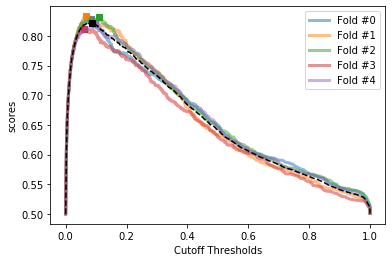

In [33]:
plot_cv_scores(results, "Balanced accuracy")

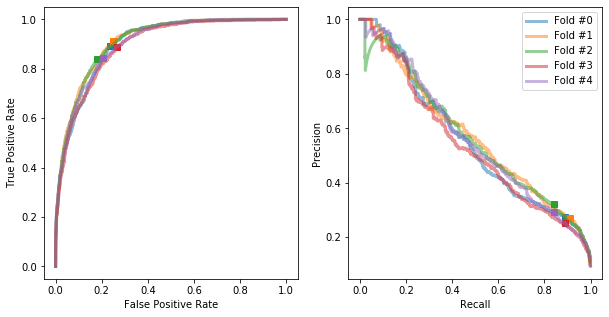

In [35]:
plot_roc_pr_curves(results)

Refit the model on the full training set and check the performance on the testing set with the threshold which correspond to the best mean score on the validation sets across the differnt folds.

In [36]:
model = clone(lr_clf)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= results["threshold"]).astype(int)))

0.8148965737336926


## Single train-test split

In [25]:
results = find_threshold_by_single_split(
    lr_clf, X_train, y_train,
    random_state=42,
    predict_method="predict_proba",
    score_method=balanced_accuracy_score,
    n_thresholds=1000
)

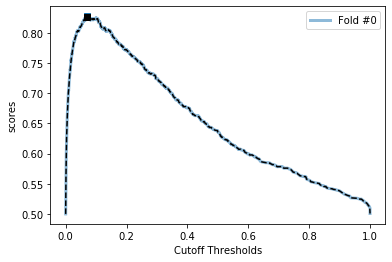

In [27]:
plot_cv_scores(results, "Balanced accuracy")

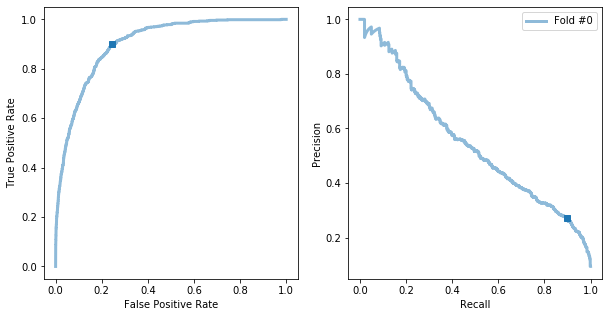

In [28]:
plot_roc_pr_curves(results)

Refit the model on the full training set and check the performance on the testing set with the threshold which correspond to the best mean score on the validation sets across the differnt folds.

In [29]:
model = clone(lr_clf)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= results["threshold"]).astype(int)))

0.81161155578186


## `cross_val_predict`

In [44]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(shuffle=True, random_state=0, n_splits=5)
results = find_threshold_by_cross_val_predict(
    lr_clf, X_train, y_train, cv,
    predict_method="predict_proba",
    score_method=balanced_accuracy_score,
    n_thresholds=1000,
)

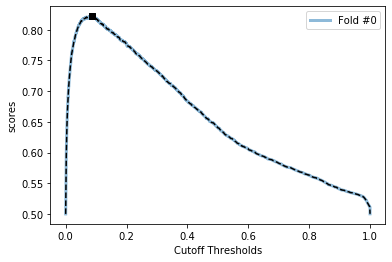

In [45]:
plot_cv_scores(results, "Balanced accuracy")

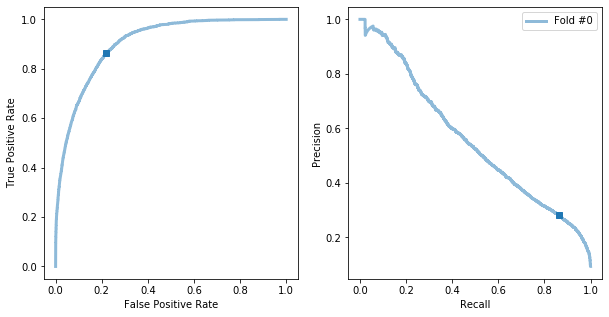

In [46]:
plot_roc_pr_curves(results)

Refit the model on the full training set and check the performance on the testing set with the threshold which correspond to the best mean score on the validation sets across the differnt folds.

In [47]:
model = clone(lr_clf)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= results["threshold"]).astype(int)))

0.8148965737336926
